In [10]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt

# data loading
from torch.utils.data.dataloader import DataLoader

transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_path = "archive/seg_train/seg_train"
test_path = "archive/seg_test/seg_test"
train_data = ImageFolder(root=train_path, transform=transform)
test_data = ImageFolder(root=test_path, transform=transform)
print(f"Number of training samples: {len(train_data)}")
print(f"Number of test samples: {len(test_data)}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from dataclasses import dataclass

@dataclass
class Config:
    num_classes: int = 6
    num_epochs: int = 1
    batch_size: int = 1024
    learning_rate: float = 1e-4
    img_size: tuple = (150, 150)
    num_channels: int = 3
    dropout: float = 0.5

train_loader = DataLoader(train_data, batch_size=Config.batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=Config.batch_size*2, shuffle=True, pin_memory=True)

class AlaxNet(nn.Module):
    def __init__(self, config):
        # super(AlaxNet, self).__init__()
        super().__init__()
        self.config = config
        self.conv_net = nn.ModuleDict(dict(
            cv1 = nn.Conv2d(config.num_channels, 96, kernel_size=8, stride=2),
            ac1 = nn.ReLU(),
            mp1 = nn.MaxPool2d(kernel_size=3, stride=2),

            cv2 = nn.Conv2d(96, 256, kernel_size=4, padding=2),
            ac2 = nn.ReLU(),
            mp2 = nn.MaxPool2d(kernel_size=3, stride=2),

            cv3 = nn.Conv2d(256, 384, kernel_size=3, padding=1),
            ac3 = nn.ReLU(),

            cv4 = nn.Conv2d(384, 384, kernel_size=3, padding=1),
            ac4 = nn.ReLU(),

            cv5 = nn.Conv2d(384, 256, kernel_size=3, padding=1),
            ac5 = nn.ReLU(),
            mp3 = nn.MaxPool2d(kernel_size=3, stride=2)
        ))
        self.MLP = nn.ModuleDict(dict(
            fc1 = nn.Linear(256*8*8, 2048),
            ac1 = nn.ReLU(),
            dp1 = nn.Dropout(self.config.dropout),

            fc2 = nn.Linear(2048, 2048),
            ac2 = nn.ReLU(),
            dp2 = nn.Dropout(self.config.dropout),

            fc3 = nn.Linear(2048, self.config.num_classes)
        ))

    def _init_weights(self, module):
        if isinstance(module, nn.Conv2d):
            nn.init.kaiming_normal_(module.weight)
            nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Linear):
            nn.init.kaiming_normal_(module.weight)
            nn.init.zeros_(module.bias)

    def forward(self, x, target=None):
        x = self.conv_net.cv1(x)
        x = self.conv_net.ac1(x)
        x = self.conv_net.mp1(x)

        x = self.conv_net.cv2(x)
        x = self.conv_net.ac2(x)
        x = self.conv_net.mp2(x)

        x = self.conv_net.cv3(x)
        x = self.conv_net.ac3(x)

        x = self.conv_net.cv4(x)
        x = self.conv_net.ac4(x)

        x = self.conv_net.cv5(x)
        x = self.conv_net.ac5(x)
        x = self.conv_net.mp3(x)
        # print(x.shape)

        x = x.view(x.size(0), -1)

        x = self.MLP.fc1(x)
        x = self.MLP.ac1(x)
        x = self.MLP.dp1(x)

        x = self.MLP.fc2(x)
        x = self.MLP.ac2(x)
        x = self.MLP.dp2(x)

        x = self.MLP.fc3(x)

        loss = None
        if target is not None:
            loss = F.cross_entropy(x, target)
        return x, loss


# training loop

def train_loop(dataloader, model, optimizer):
    size = len(dataloader.dataset)
    lossi = []
    for batch, (X, y) in enumerate(dataloader):
        # model.train()
        X, y = X.to(device), y.to(device)
        # Compute prediction error
        pred, loss = model(X, y)
        lossi.append(loss.item())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        # Gradient clipping
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        if batch % 100 == 0:
            train_loss, current = loss.item(), batch * len(X)
            model.eval()
            with torch.no_grad():
                pred, val_loss = model(X, y)
                print(f"loss: {train_loss:>7f} | Validation loss: {val_loss:>7f} | [{current:>5d}/{size:>5d}]")
    return lossi




def test_loop(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred, loss = model(X, y)
            test_loss += loss.item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


torch.random.manual_seed(42)
model = AlaxNet(Config).to(device)
# torch.compile(model)
model.train()

optimizer = torch.optim.AdamW(model.parameters(), lr=Config.learning_rate)

# print num params
num_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {num_params}")

for epoch in range(Config.num_epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    lossi = train_loop(train_loader, model, optimizer)
    test_loop(test_loader, model)
print("Done!")

Number of training samples: 14034
Number of test samples: 3000
Number of parameters: 41274726
Epoch 1
-------------------------------


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.90 GiB. GPU 0 has a total capacity of 11.76 GiB of which 1.13 GiB is free. Process 6221 has 872.00 MiB memory in use. Including non-PyTorch memory, this process has 9.76 GiB memory in use. Of the allocated memory 8.77 GiB is allocated by PyTorch, and 877.40 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

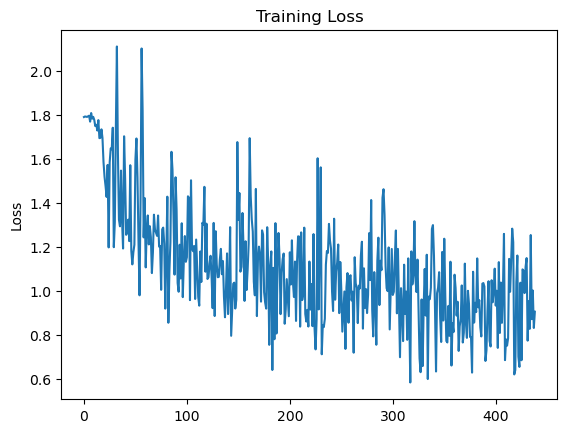

In [ ]:

plt.plot(lossi)
plt.xlabel('')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()